# 4_Plume_Analysis

In [4]:
%load_ext autoreload
%autoreload 2

import glob
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from plume_learn.plume_utils.viz import show_images, label_violinplot
from plume_learn.plume_utils.manage_plume import remove_all_0_plume, load_json
from plume_learn.plume_analyzer.PlumeDataset import plume_dataset
from m3util.viz.layout import layout_fig
from m3util.viz.text import labelfigs, add_text_to_figure
from m3util.viz.lines import draw_lines
from sro_sto_plume.modify_df import modify_df

## 1. Load Plume data

### 1.1 load experiment conditions

In [9]:
growth_names = ['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4', 'Sample 5', 'Sample X']
growth_ids = ['YG065', 'YG066', 'YG067', 'YG068', 'YG069', 'YG063']
plume_recording_root = '../data/Plumes/plume_recordings/plume_recordings/'
output_root = '../data/Plumes/plume_metrics/'

### 1.2 load metrics for every plume frame

In [10]:
df_frame_metrics = []
for id, growth_name in zip(growth_ids, growth_names):
    file = glob.glob(f'{output_root}/{id}*metrics.csv')[0]
    df = pd.read_csv(file)
    df_processed = modify_df(df, id, growth_name)
    df_frame_metrics.append(df_processed)
df_frame_metrics = pd.concat(df_frame_metrics, ignore_index=True)
df_frame_metrics

C:\Users\yig319\AppData\Local\Temp\ipykernel_20136\4126169575.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
C:\Users\yig319\AppData\Local\Temp\ipykernel_20136\4126169575.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
C:\Users\yig319\AppData\Local\Temp\ipykernel_20136\4126169575.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
C:\Users\yig319\AppData\Local\Temp\ipykernel_20136\4126169575.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
C:\Users\yig319\AppData\Local\Temp\ipykernel_20136\4126169575.py:4: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
C:\Users\yig319\AppData\Local\Temp\

,Plume Index,Time (µs),Distance (m),Velocity (m/s),Area (a.u.),Threshold,Growth Name,Growth_ID
0,0,0.0,0.000000,0.000000,0.0,200,Sample 1,YG065
1,0,0.5,0.000000,0.000000,0.0,200,Sample 1,YG065
2,0,1.0,0.008715,17429.394813,2074.0,200,Sample 1,YG065
3,0,1.5,0.014784,12138.328530,3144.0,200,Sample 1,YG065
4,0,2.0,0.021476,13383.285303,9039.0,200,Sample 1,YG065
...,...,...,...,...,...,...,...,...
280955,377,61.5,0.032836,0.000000,0.0,200,Sample X,YG063
280956,377,62.0,0.032836,0.000000,0.0,200,Sample X,YG063
280957,377,62.5,0.032836,0.000000,0.0,200,Sample X,YG063
280958,377,63.0,0.032836,0.000000,0.0,200,Sample X,YG063


### 1.3 calculate max area and incident velocity

In [11]:
# analyze the max area
idx = df_frame_metrics.groupby(['Growth Name', 'Plume Index'])['Area (a.u.)'].idxmax()
df_max_area = df_frame_metrics.loc[idx, ['Growth Name', 'Plume Index', 'Time (µs)', 'Area (a.u.)']].reset_index(drop=True)
df_max_area.rename(columns={'Area (a.u.)': 'Max Area (a.u.)'}, inplace=True)
df_max_area.rename(columns={'Time (µs)': 'Time at Max Area (µs)'}, inplace=True)

# analyze plume Velocity that can be tracked before landing on the substrate
## calculate the velocity between 2.8cm and 2.9cm for the incident velocity
df_filtered = df_frame_metrics[(df_frame_metrics['Distance (m)'] >= 0.028) & (df_frame_metrics['Distance (m)'] <= 0.029)] 
df_unique = df_filtered.drop_duplicates(subset=['Time (µs)', 'Distance (m)', 'Velocity (m/s)', 'Area (a.u.)', 'Threshold'])
incident_Velocity = df_unique.groupby(['Growth Name', 'Plume Index'])['Velocity (m/s)'].mean().reset_index()
incident_Velocity.rename(columns={'Velocity (m/s)': 'Incident Velocity (m/s)'}, inplace=True)

df_plume_metrics = pd.merge(df_max_area, incident_Velocity, on=['Growth Name', 'Plume Index'])
df_plume_metrics.sample(5)

,Growth Name,Plume Index,Time at Max Area (µs),Max Area (a.u.),Incident Velocity (m/s)
265,Sample 2,218,3.0,15446.0,5291.066282
177,Sample 2,57,3.5,18368.0,6224.783862
787,Sample 5,274,3.0,15942.0,6224.783862
84,Sample 1,218,3.0,15933.0,5602.305476
895,Sample X,217,3.0,16171.0,5602.305476


## 2. Introduction to Plume Dynamics Analysis

### 2.1 Load plumes

In [10]:
file = f'{plume_recording_root}/YG065_YichenGuo_09102024.h5'
plume_ds = plume_dataset(file_path=file, group_name='PLD_Plumes')
keys = plume_ds.dataset_names()
plumes = plume_ds.load_plumes('1-SrRuO3')

### 2.2 Visualize Plume Images in Batch

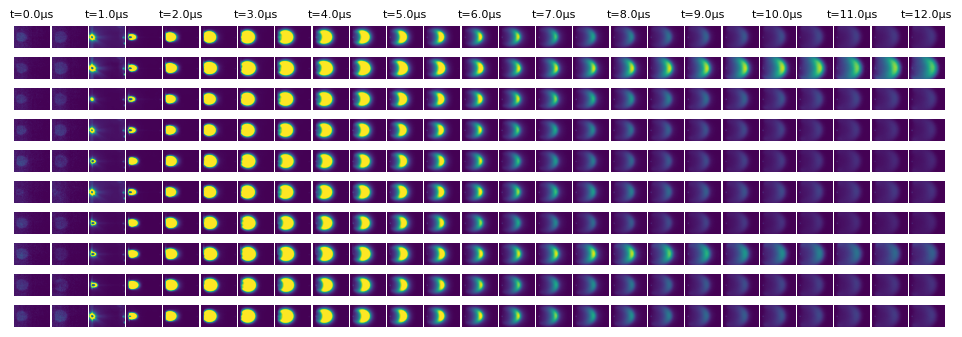

In [110]:
sample_frames = plumes[10:20, :25]
sample_frames = np.array(sample_frames).reshape(10*25, 250, 400)
labels = np.arange(25)*500e-3
labels = [f't={l:.1f}µs' for l in labels]
labels = labels*10
fig, axes = layout_fig(25*10, mod=25, figsize=(12, 4), subplot_style='gridspec', spacing=(0.05, 0.05), layout='tight')
for i, (ax, img, label) in enumerate(zip(axes, sample_frames, labels)):
    ax.imshow(img)
    ax.axis('off')
    if i < 25 and i % 2 == 0:
        ax.set_title(label, fontsize=8)
        
# show_images(sample_frames, labels=None, img_per_row=25, title=None, fig=fig, axes=axes, label_size=8)
plt.savefig('../figures/s4_Plume_Sample_Frames.png', dpi=600)
plt.savefig('../figures/s4_Plume_Sample_Frames.svg', dpi=600)
plt.show()

### 2.3 Visualize the plume metric history

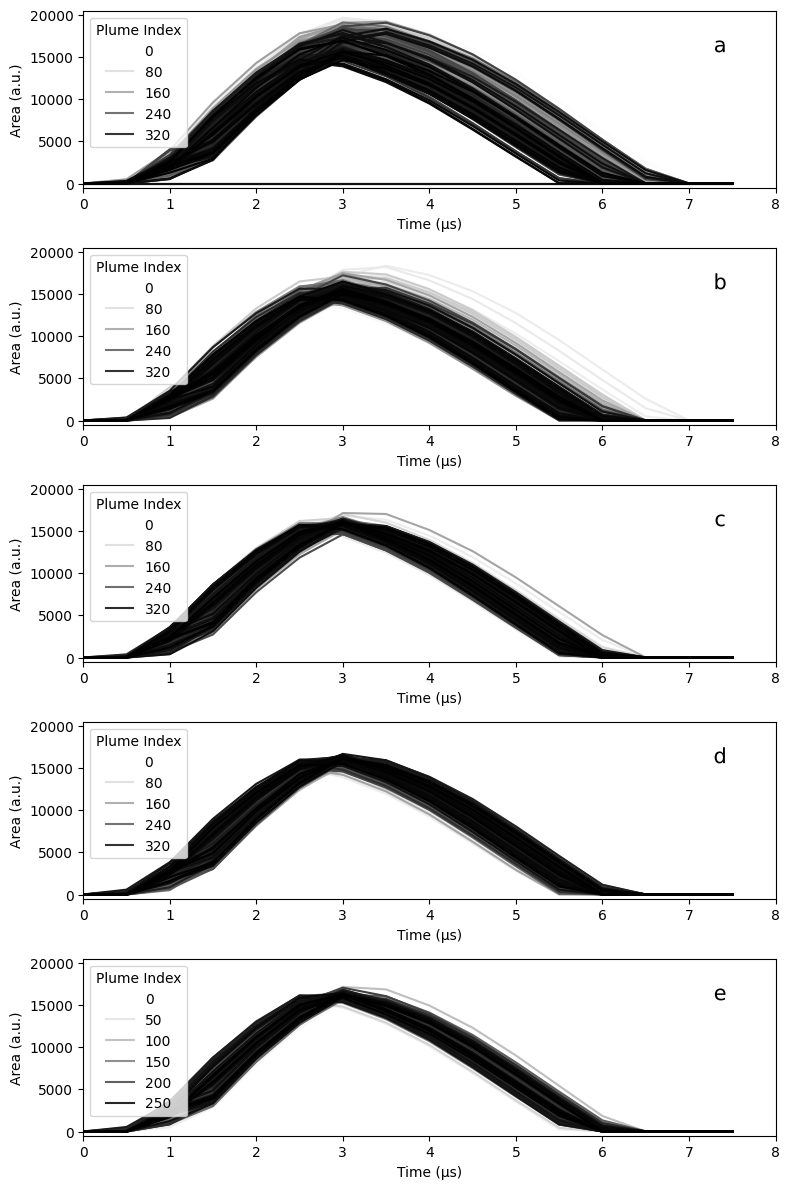

In [176]:
df_sample = df_frame_metrics[(df_frame_metrics['Time (µs)'] >= 0) & (df_frame_metrics['Time (µs)'] < 8)] 

fig, axes = plt.subplots(5, 1, figsize=(8, 3*4))
for i, (ax, growth) in enumerate(zip(axes, growth_names)):
    
    # Create the first lineplot
    lineplot1 = sns.lineplot(x="Time (µs)", y="Area (a.u.)", hue="Plume Index", data=df_sample[df_sample['Growth Name'] == growth], ax=ax, palette='Greys')

    # Get the handles and labels specifically for the first plot (Plume Index)
    handles1, labels1 = lineplot1.get_legend().legend_handles, [t.get_text() for t in lineplot1.get_legend().get_texts()]
    legend1 = ax.legend(handles=handles1, labels=labels1, title="Plume Index", loc='upper left')

    ax.set_xlim(0, 8)
    ax.set_ylim(-500, 20500)
    labelfigs(ax, i, style='bw', loc='tr', size=15, inset_fraction=(0.2, 0.08))
    
plt.tight_layout()
plt.show()

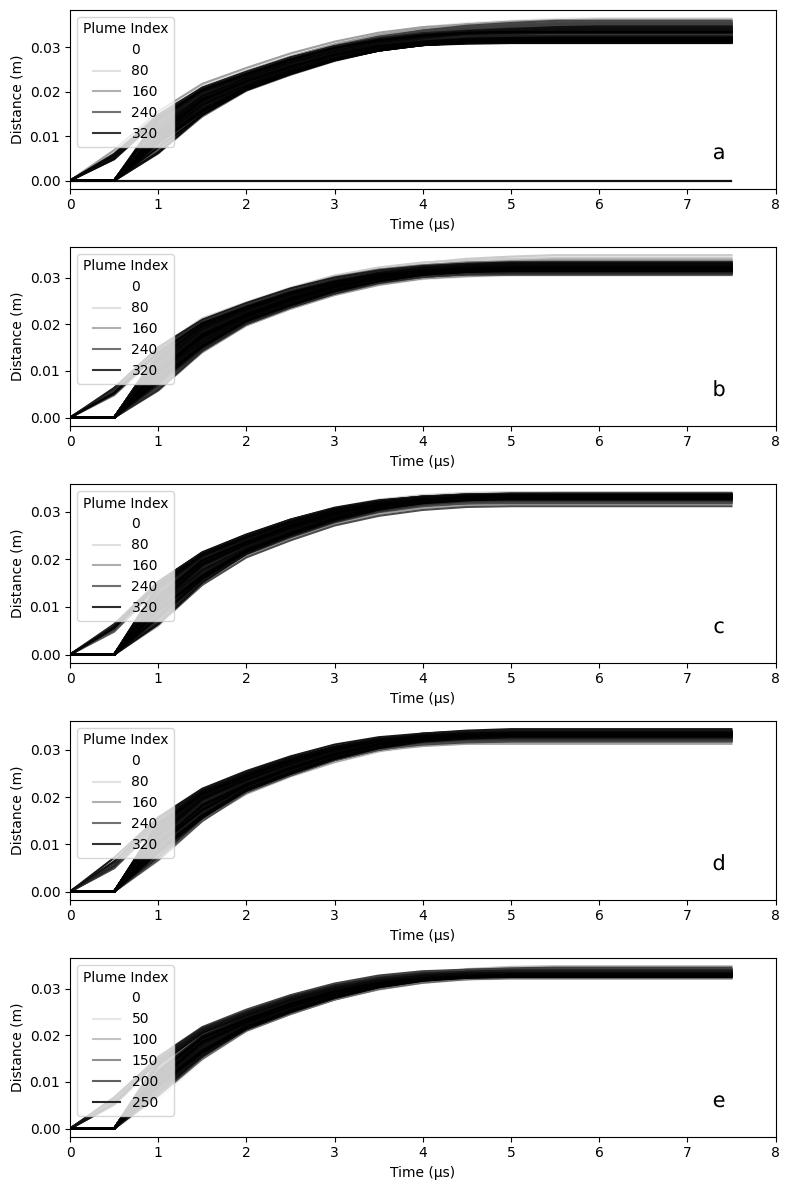

In [177]:
df_sample = df_frame_metrics[(df_frame_metrics['Time (µs)'] >= 0) & (df_frame_metrics['Time (µs)'] < 8)] 

fig, axes = plt.subplots(5, 1, figsize=(8, 3*4))
for i, (ax, growth) in enumerate(zip(axes, growth_names)):
    
    # Create the first lineplot
    lineplot1 = sns.lineplot(x="Time (µs)", y="Distance (m)", hue="Plume Index", data=df_sample[df_sample['Growth Name'] == growth], ax=ax, palette='Greys')

    # Get the handles and labels specifically for the first plot (Plume Index)
    handles1, labels1 = lineplot1.get_legend().legend_handles, [t.get_text() for t in lineplot1.get_legend().get_texts()]
    legend1 = ax.legend(handles=handles1, labels=labels1, title="Plume Index", loc='upper left')

    ax.set_xlim(0, 8)
    labelfigs(ax, i, style='bw', loc='br', size=15, inset_fraction=(0.2, 0.08))
    
plt.tight_layout()
plt.show()

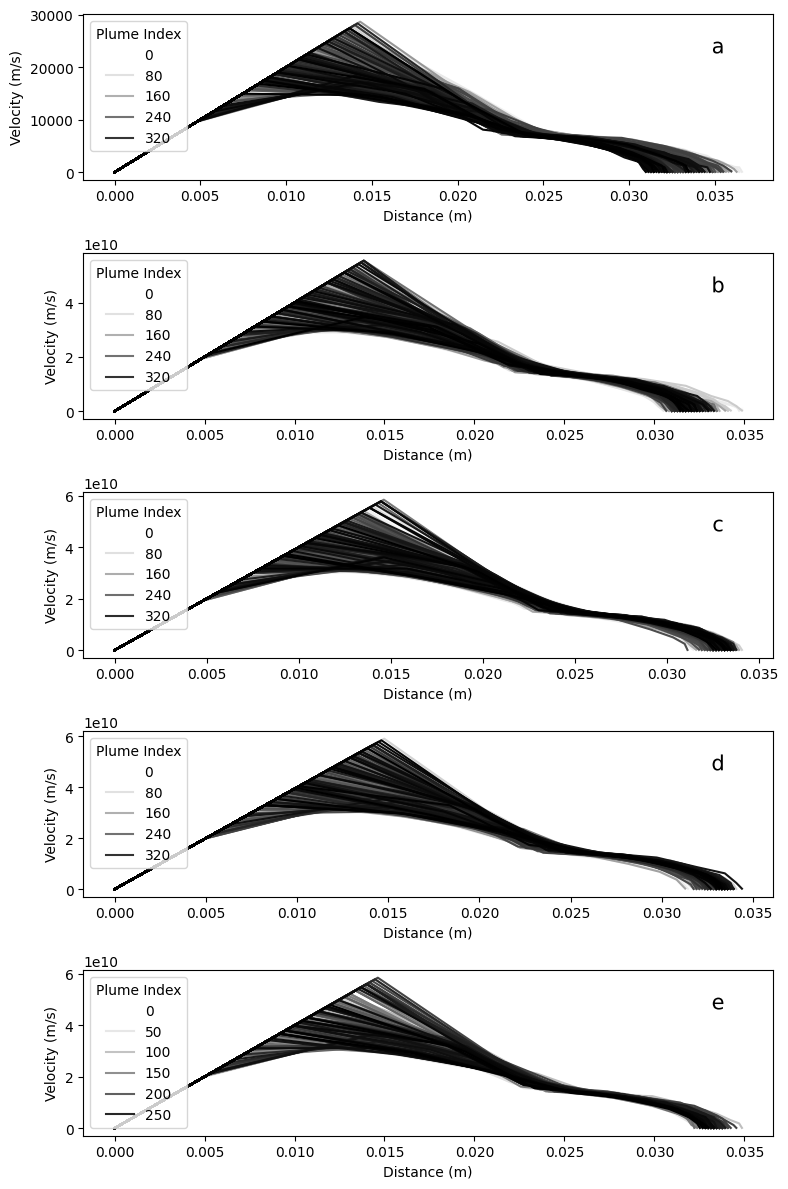

In [178]:
df_sample = df_frame_metrics[(df_frame_metrics['Time (µs)'] >= 0) & (df_frame_metrics['Time (µs)'] < 8)] 

fig, axes = plt.subplots(5, 1, figsize=(8, 3*4))
for i, (ax, growth) in enumerate(zip(axes, growth_names)):
    
    # Create the first lineplot
    lineplot1 = sns.lineplot(x="Distance (m)", y="Velocity (m/s)", hue="Plume Index", data=df_sample[df_sample['Growth Name'] == growth], ax=ax, palette='Greys')

    # Get the handles and labels specifically for the first plot (Plume Index)
    handles1, labels1 = lineplot1.get_legend().legend_handles, [t.get_text() for t in lineplot1.get_legend().get_texts()]
    legend1 = ax.legend(handles=handles1, labels=labels1, title="Plume Index", loc='upper left')

    labelfigs(ax, i, style='bw', loc='tr', size=15, inset_fraction=(0.2, 0.08))
    
plt.tight_layout()
plt.show()

### 2.4 Visualize plume area, distance and velocity

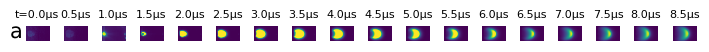

In [16]:
sample_frames = plumes[0][0:18]
labels = np.arange(len(sample_frames))*500e-3
labels = [f'{l:.1f}µs' for l in labels]
labels[0] = 't='+labels[0]
fig, axes = layout_fig(18, mod=18, figsize=(7, 1.5), layout='tight')
show_images(sample_frames, labels=labels, img_per_row=18, title=None, fig=fig, axes=axes, label_size=8)
labelfigs(axes[0], 0, style='bw', loc='tl', size=15,  inset_fraction=(0.4, -0.4))
plt.savefig('../figures/Plume_Evolution.png', dpi=600)
plt.savefig('../figures/Plume_Evolution.svg', dpi=600)
plt.show()

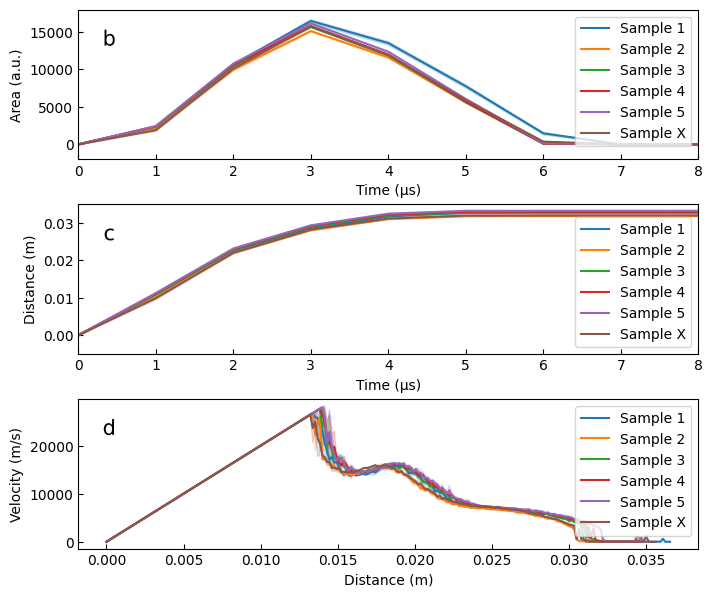

In [12]:
fig, axes = layout_fig(3, mod=1, figsize=(8, 7), subplot_style='gridspec', spacing=(0, 0.3), layout='tight')
df_filtered = df_frame_metrics[df_frame_metrics['Time (µs)'].isin(range(0, 9))]
lineplot = sns.lineplot(x="Time (µs)", y="Area (a.u.)", hue='Growth Name', data=df_filtered, ax=axes[0])
axes[0].set_xlim(0, 8)
axes[0].set_ylim(-2000, 18000)
labelfigs(axes=axes[0], number=1, size=15, style='bw', inset_fraction=(0.2, 0.05))
axes[0].legend(fontsize=10)

lineplot = sns.lineplot(x="Time (µs)", y="Distance (m)", hue='Growth Name', data=df_filtered, ax=axes[1])
axes[1].set_xlim(0, 8)
axes[1].set_ylim(-0.005, 0.035)
labelfigs(axes=axes[1], number=2, size=15, style='bw', inset_fraction=(0.2, 0.05))
axes[1].legend(fontsize=10)

lineplot = sns.lineplot(x="Distance (m)", y="Velocity (m/s)", hue='Growth Name', data=df_frame_metrics, ax=axes[2])
labelfigs(axes=axes[2], number=3, size=15, style='bw', inset_fraction=(0.2, 0.05))
axes[2].legend(fontsize=10)

for ax in axes:
    ax.tick_params(axis='both', direction='in', labelsize=10)

plt.savefig('../figures/3_Plume_area_distance_velocity_average.png', dpi=600)
plt.savefig('../figures/3_Plume_area_distance_velocity_average.svg', dpi=600)
plt.show()

### 2.3 Violin Plot of Plume Max Area and Incident Velocity Statics

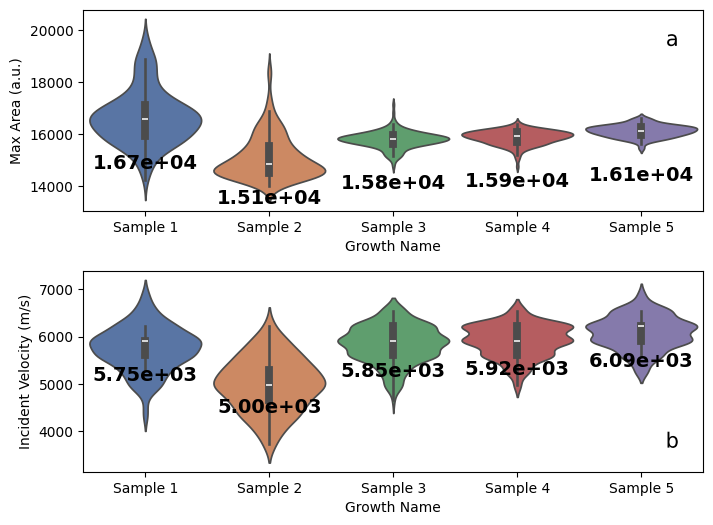

In [62]:
fig, axes = layout_fig(2, 1, figsize=(8, 6), subplot_style='gridspec', spacing=(0, 0.3), layout='tight')

sns.violinplot(x='Growth Name', y='Max Area (a.u.)', data=df_plume_metrics, width=0.9, ax=axes[0], palette='deep', hue='Growth Name', legend=False)
mean_max_area = df_plume_metrics.groupby('Growth Name')['Max Area (a.u.)'].mean()
label_violinplot(axes[0], mean_max_area, label_type='average_value', text_pos='center', value_format='scientific',
                 offset_parms={'x_type': 'fixed', 'x_value': 0, 'y_type': 'ratio', 'y_value': -0.12})
labelfigs(axes=axes[0], number=0, size=15, style='bw', loc='tr', inset_fraction=(0.15, 0.05))

sns.violinplot(x='Growth Name', y='Incident Velocity (m/s)', data=df_plume_metrics, width=0.9, ax=axes[1], palette='deep', hue='Growth Name', legend=False)
mean_incident_velocity = df_plume_metrics.groupby('Growth Name')['Incident Velocity (m/s)'].mean()
label_violinplot(axes[1], mean_incident_velocity, label_type='average_value', text_pos='center', value_format='scientific',
                 offset_parms={'x_type': 'fixed', 'x_value': 0, 'y_type': 'ratio', 'y_value': -0.12})
labelfigs(axes=axes[1], number=1, size=15, style='bw', loc='br', inset_fraction=(0.15, 0.05))

plt.savefig('../figures/4_Plume_metrics_violinplot.png', dpi=600)
plt.savefig('../figures/4_Plume_metrics_violinplot.svg', dpi=600)
plt.show()